In [104]:
import hbcvt
import numpy as np
import math
import serial
import time
import queue
import pandas as pd

R = 1.5 / 2
R_TO_R = 2.5
B_TO_B_X = 4.5
B_TO_B_Y = 5
Z_AXIS = 0.6
PAPER_X = 210
PAPER_Y = 297
X_TOL = 10
Y_TOL = 10
B_SIZE = np.array([R_TO_R + B_TO_B_X, 2 * R_TO_R + B_TO_B_Y])
MAX_X_LINE = math.floor((PAPER_X - 2 * X_TOL) / B_SIZE[0])
MAX_Y_LINE = math.floor((PAPER_Y - 2 * Y_TOL) / B_SIZE[1])

br_arr = np.zeros((3 * MAX_Y_LINE, 2 *MAX_X_LINE))

spec_coin = 0
alphabet_coin = 0
st_coin = 0

mac_list1 = ['것', '을', '은', '인']
mac_br1 = [[[0, 0, 0, 1, 1, 1], [0, 1, 1, 1, 0, 0]],
          [[0, 1, 1, 1, 0, 1]],
          [[1, 0, 1, 0, 1, 1]],
          [[1, 1, 1, 1, 1, 0]]]
mac_list2 = ['그래서', '그러나', '그러면', '그러므로', '그런데', '그리고', '그리하여']
mac_br2 = [[[1, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0]],
          [[1, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0]],
          [[1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0]],
          [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1]],
          [[1, 0, 0, 0, 0, 0], [1, 0, 1, 1, 1, 0]],
          [[1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1]],
          [[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 1]]]

spec_list = ['(', ')', '-', '~']
spec_br = [[[0, 0, 1, 0, 0, 1]],
           [[0, 0, 1, 0, 0, 1]],
           [[0, 0, 1, 0, 0, 1]],
           [[0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 1]]]
st_list = ['ㅃ', 'ㅉ', 'ㄸ', 'ㄲ', 'ㅆ']

def find_specific_str(s, ss):
    i = 0
    return_list1 = []
    while True:
        k = s.find(ss, i)
        if  k != -1:
            return_list1.append(s[i: k])
            return_list1.append(ss)
            i = k + len(ss)
        if s.find(ss, i) == -1:
            return_list1.append(s[i:])
            break
    return_list2 = []
    for i in return_list1:
        if i != '':
            return_list2.append(i)
    return return_list2

def refine_str(input_str):
    vol_result = []
    
    """공백문자 마법사"""
    
    result = find_specific_str(input_str, ' ')
    print(result)
    
    """숫자 마법사"""
    
    for i in range(len(result)):
        number_coin = 0    # 상태 숫자 = 1 , 문자 = 0
        number_state = False
        for j in range(len(result[i])):
            if j == 0:
                number_state = result[i][j].isdigit()
            if number_state != result[i][j].isdigit():
                vol_result.append(result[i][number_coin: j])
                number_state = result[i][j].isdigit()
                number_coin = j
            if j == len(result[i]) - 1:
                vol_result.append(result[i][number_coin: j + 1])
                
    result = vol_result
    vol_result = []
    print(result)
    
    """엔터 마법사"""
    
    for i in range(len(result)):
        vol_list = find_specific_str(result[i], '\n')
        for j in range(len(vol_list)):
            vol_result.append(vol_list[j])
            
    result = vol_result
    vol_result = []
    print(result)
    
    """매크로1 마법사"""
    
    for k1 in range(len(mac_list1)):
        vol_result = []
        for i in range(len(result)):
            vol_list = find_specific_str(result[i], mac_list1[k1])
            for j in range(len(vol_list)):
                vol_result.append(vol_list[j])
        result = vol_result
    
    result = vol_result
    vol_result = []
    print(result)
    
    """매크로2 마법사"""
    
    for k2 in range(len(mac_list2)):
        vol_result = []
        for i in range(len(result)):
            vol_list = find_specific_str(result[i], mac_list2[k2])
            for j in range(len(vol_list)):
                vol_result.append(vol_list[j])
        result = vol_result
    
    result = vol_result
    vol_result = []
    print(result)
    
    """특수문자 마법사"""
    
    for k3 in range(len(spec_list)):
        vol_result = []
        for i in range(len(result)):
            vol_list = find_specific_str(result[i], spec_list[k3])
            for j in range(len(vol_list)):
                vol_result.append(vol_list[j])
        result = vol_result
    
    result = vol_result
    vol_result = []
    
    print(result)
    return result

def interpreter(input_str):
    result = []
    vol_result = []
    
    if input_str == ' ':
        print('공백')
        vol_result.append([0, 0, 0, 0, 0, 0])
    
    elif input_str in mac_list1:
        print('매크로1')
        for i in mac_br1[mac_list1.index(input_str)]:
            vol_result.append(i)
    
    elif input_str in mac_list2:
        print('매크로2')
        for i in mac_br2[mac_list2.index(input_str)]:
            vol_result.append(i)
        
    elif input_str[0].isdigit():
        print('숫자')
        vol_hbcvt = hbcvt.h2b.text(input_str)
        vol_result.append([0, 0, 1, 1, 1, 1])
        for i in range(len(vol_hbcvt)):
            for j in range(len(vol_hbcvt[i][1])):
                vol_result.append(vol_hbcvt[i][1][j][1][1])
            
    elif input_str[0].isalpha():
        print('한글알파벳')
        vol_hbcvt = hbcvt.h2b.text(input_str)
        for i in range(len(vol_hbcvt)):
            for j in range(len(vol_hbcvt[i][1])):
                for k in range(len(vol_hbcvt[i][1][j][1])):
                    vol_result.append(vol_hbcvt[i][1][j][1][k])
                    
    elif input_str in spec_list:
        print('특수문자')
        for i in spec_br[spec_list.index(input_str)]:
            vol_result.append(i)
    
    elif input_str[0] == '\n':
        print('엔터')
        vol_result.append(['#1'])
    
    else:
        print('뭔지 모르겠음')
        vol_hbcvt = hbcvt.h2b.text(input_str)
        for i in range(len(vol_hbcvt)):
            for j in range(len(vol_hbcvt[i][1])):
                for k in range(len(vol_hbcvt[i][1][j][1])):
                    vol_result.append(vol_hbcvt[i][1][j][1][k])
    
    result = vol_result
    vol_result = []
    print(len(result))
    
    return result

def interpreter_to_a4(br_result, input_set, cursor):
    vol_br_paper = br_result
    vol_cursor = cursor
    max_y, max_x = vol_br_paper.shape
    for i in range(len(input_set)):
        for j in range(len(input_set[i])):
            if input_set[i][j][0] == '#1':
                print('엔터')
                vol_cursor = [0, vol_cursor[1] + 3]
            else:
                print('글자')
                if vol_cursor[0] == max_x:
                    print('줄바꿈')
                    vol_cursor = [0, vol_cursor[1] + 3]
                else:
                    print('글쓰기')
                    vol_br_paper[vol_cursor[1]][vol_cursor[0]] = input_set[i][j][0]
                    vol_cursor = [vol_cursor[0], vol_cursor[1] + 1]
                    vol_br_paper[vol_cursor[1]][vol_cursor[0]] = input_set[i][j][1]
                    vol_cursor = [vol_cursor[0], vol_cursor[1] + 1]
                    vol_br_paper[vol_cursor[1]][vol_cursor[0]] = input_set[i][j][2]
                    vol_cursor = [vol_cursor[0] + 1, vol_cursor[1] - 2]
                    vol_br_paper[vol_cursor[1]][vol_cursor[0]] = input_set[i][j][3]
                    vol_cursor = [vol_cursor[0], vol_cursor[1] + 1]
                    vol_br_paper[vol_cursor[1]][vol_cursor[0]] = input_set[i][j][4]
                    vol_cursor = [vol_cursor[0], vol_cursor[1] + 1]
                    vol_br_paper[vol_cursor[1]][vol_cursor[0]] = input_set[i][j][5]
                    vol_cursor = [vol_cursor[0] + 1, vol_cursor[1] - 2]
            print(vol_cursor)
    return cursor, br_result

def a4_to_block(br_result):
    return_list = np.zeros((MAX_Y_LINE, MAX_X_LINE))
    for i in range(MAX_Y_LINE):
        for j in range(MAX_X_LINE):
            if not br_result[3 * i: 3 * i + 3, 2 * j: 2 * j + 2].any():
                return_list[i][j] = 0
            else:
                return_list[i][j] = 1
    return return_list

def return_two_end_points(input_list):
    st_point = 0
    end_point = len(input_list)
    st_token = 0
    end_token = 0
    for i in range(end_point):
        if input_list[i] != 0 and st_token == 0:
            st_point = i
            st_token = 1
        if input_list[len(input_list) - 1 - i] != 0 and end_token == 0:
            end_point = len(input_list) - 1 - i
            end_token = 1
    if st_token == 0 and end_token == 0:
        return -1, -1
    else:
        return st_point, end_point

In [105]:
vvvvv = """
창제자는 송암 박두성(1888~1963) 선생으로, 일제강점기부터 교직 생활을 하면서 
시각 장애인들을 가르치고 자립을 도와주었으며, 한글 점자인 '훈맹정음'을 창안하였고, 
성경점자책을 만들기 위해 몸을 혹사하면서까지 점자판을 개발하셨다.
"""



In [106]:
arrrr = refine_str(vvvvv)

['\n창제자는', ' ', '송암', ' ', '박두성(1888~1963)', ' ', '선생으로,', ' ', '일제강점기부터', ' ', '교직', ' ', '생활을', ' ', '하면서', ' ', '\n시각', ' ', '장애인들을', ' ', '가르치고', ' ', '자립을', ' ', '도와주었으며,', ' ', '한글', ' ', '점자인', ' ', "'훈맹정음'을", ' ', '창안하였고,', ' ', '\n성경점자책을', ' ', '만들기', ' ', '위해', ' ', '몸을', ' ', '혹사하면서까지', ' ', '점자판을', ' ', '개발하셨다.\n']
['\n창제자는', ' ', '송암', ' ', '박두성(', '1888', '~', '1963', ')', ' ', '선생으로,', ' ', '일제강점기부터', ' ', '교직', ' ', '생활을', ' ', '하면서', ' ', '\n시각', ' ', '장애인들을', ' ', '가르치고', ' ', '자립을', ' ', '도와주었으며,', ' ', '한글', ' ', '점자인', ' ', "'훈맹정음'을", ' ', '창안하였고,', ' ', '\n성경점자책을', ' ', '만들기', ' ', '위해', ' ', '몸을', ' ', '혹사하면서까지', ' ', '점자판을', ' ', '개발하셨다.\n']
['\n', '창제자는', ' ', '송암', ' ', '박두성(', '1888', '~', '1963', ')', ' ', '선생으로,', ' ', '일제강점기부터', ' ', '교직', ' ', '생활을', ' ', '하면서', ' ', '\n', '시각', ' ', '장애인들을', ' ', '가르치고', ' ', '자립을', ' ', '도와주었으며,', ' ', '한글', ' ', '점자인', ' ', "'훈맹정음'을", ' ', '창안하였고,', ' ', '\n', '성경점자책을', ' ', '만들기', ' ', '위해', ' ', '몸을', ' ', '혹사하면서까지',

In [107]:
result_set = []
for i in range(len(arrrr)):
    try:
        vol_interpreter = interpreter(arrrr[i])
        print(vol_interpreter)
        _ = vol_interpreter[0][0]
        result_set.append(vol_interpreter)
    except:
        _ = 0

엔터
1
[['#1']]
한글알파벳
10
[[0, 0, 0, 0, 1, 1], [1, 1, 0, 0, 0, 1], [0, 1, 1, 0, 1, 1], [0, 0, 0, 1, 0, 1], [1, 0, 1, 1, 1, 0], [0, 0, 0, 1, 0, 1], [1, 1, 0, 0, 0, 1], [1, 0, 0, 1, 0, 0], [0, 1, 0, 1, 0, 1], [0, 1, 0, 0, 1, 0]]
공백
1
[[0, 0, 0, 0, 0, 0]]
한글알파벳
6
[[0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 1], [0, 1, 1, 0, 1, 1], [1, 1, 0, 1, 1, 0], [1, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1]]
공백
1
[[0, 0, 0, 0, 0, 0]]
한글알파벳
8
[[0, 0, 0, 1, 1, 0], [1, 1, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0], [1, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1], [0, 1, 1, 1, 0, 0], [0, 1, 1, 0, 1, 1]]
특수문자
1
[[0, 0, 1, 0, 0, 1]]
숫자
5
[[0, 0, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0], [1, 1, 0, 0, 1, 0], [1, 1, 0, 0, 1, 0]]
특수문자
2
[[0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 1]]
숫자
5
[[0, 0, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0], [1, 1, 0, 1, 0, 0], [1, 0, 0, 1, 0, 0]]
특수문자
1
[[0, 0, 1, 0, 0, 1]]
공백
1
[[0, 0, 0, 0, 0, 0]]
한글알파벳
11
[[0, 0, 0, 0, 0, 1], [0, 1, 1, 1, 0, 0], [0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0

In [108]:
_, a4 = interpreter_to_a4(br_arr, result_set, [0, 0])

엔터
[0, 3]
글자
글쓰기
[2, 3]
글자
글쓰기
[4, 3]
글자
글쓰기
[6, 3]
글자
글쓰기
[8, 3]
글자
글쓰기
[10, 3]
글자
글쓰기
[12, 3]
글자
글쓰기
[14, 3]
글자
글쓰기
[16, 3]
글자
글쓰기
[18, 3]
글자
글쓰기
[20, 3]
글자
글쓰기
[22, 3]
글자
글쓰기
[24, 3]
글자
글쓰기
[26, 3]
글자
글쓰기
[28, 3]
글자
글쓰기
[30, 3]
글자
글쓰기
[32, 3]
글자
글쓰기
[34, 3]
글자
글쓰기
[36, 3]
글자
글쓰기
[38, 3]
글자
글쓰기
[40, 3]
글자
글쓰기
[42, 3]
글자
글쓰기
[44, 3]
글자
글쓰기
[46, 3]
글자
글쓰기
[48, 3]
글자
글쓰기
[50, 3]
글자
글쓰기
[52, 3]
글자
글쓰기
[54, 3]
글자
줄바꿈
[0, 6]
글자
글쓰기
[2, 6]
글자
글쓰기
[4, 6]
글자
글쓰기
[6, 6]
글자
글쓰기
[8, 6]
글자
글쓰기
[10, 6]
글자
글쓰기
[12, 6]
글자
글쓰기
[14, 6]
글자
글쓰기
[16, 6]
글자
글쓰기
[18, 6]
글자
글쓰기
[20, 6]
글자
글쓰기
[22, 6]
글자
글쓰기
[24, 6]
글자
글쓰기
[26, 6]
글자
글쓰기
[28, 6]
글자
글쓰기
[30, 6]
글자
글쓰기
[32, 6]
글자
글쓰기
[34, 6]
글자
글쓰기
[36, 6]
글자
글쓰기
[38, 6]
글자
글쓰기
[40, 6]
글자
글쓰기
[42, 6]
글자
글쓰기
[44, 6]
글자
글쓰기
[46, 6]
글자
글쓰기
[48, 6]
글자
글쓰기
[50, 6]
글자
글쓰기
[52, 6]
글자
글쓰기
[54, 6]
글자
줄바꿈
[0, 9]
글자
글쓰기
[2, 9]
글자
글쓰기
[4, 9]
글자
글쓰기
[6, 9]
글자
글쓰기
[8, 9]
글자
글쓰기
[10, 9]
글자
글쓰기
[12, 9]
글자
글쓰기
[14, 9]
글자
글쓰기
[16, 9]
글자
글쓰기
[18, 9]
글자
글쓰기
[20, 9]
글자
글쓰기
[22, 9]

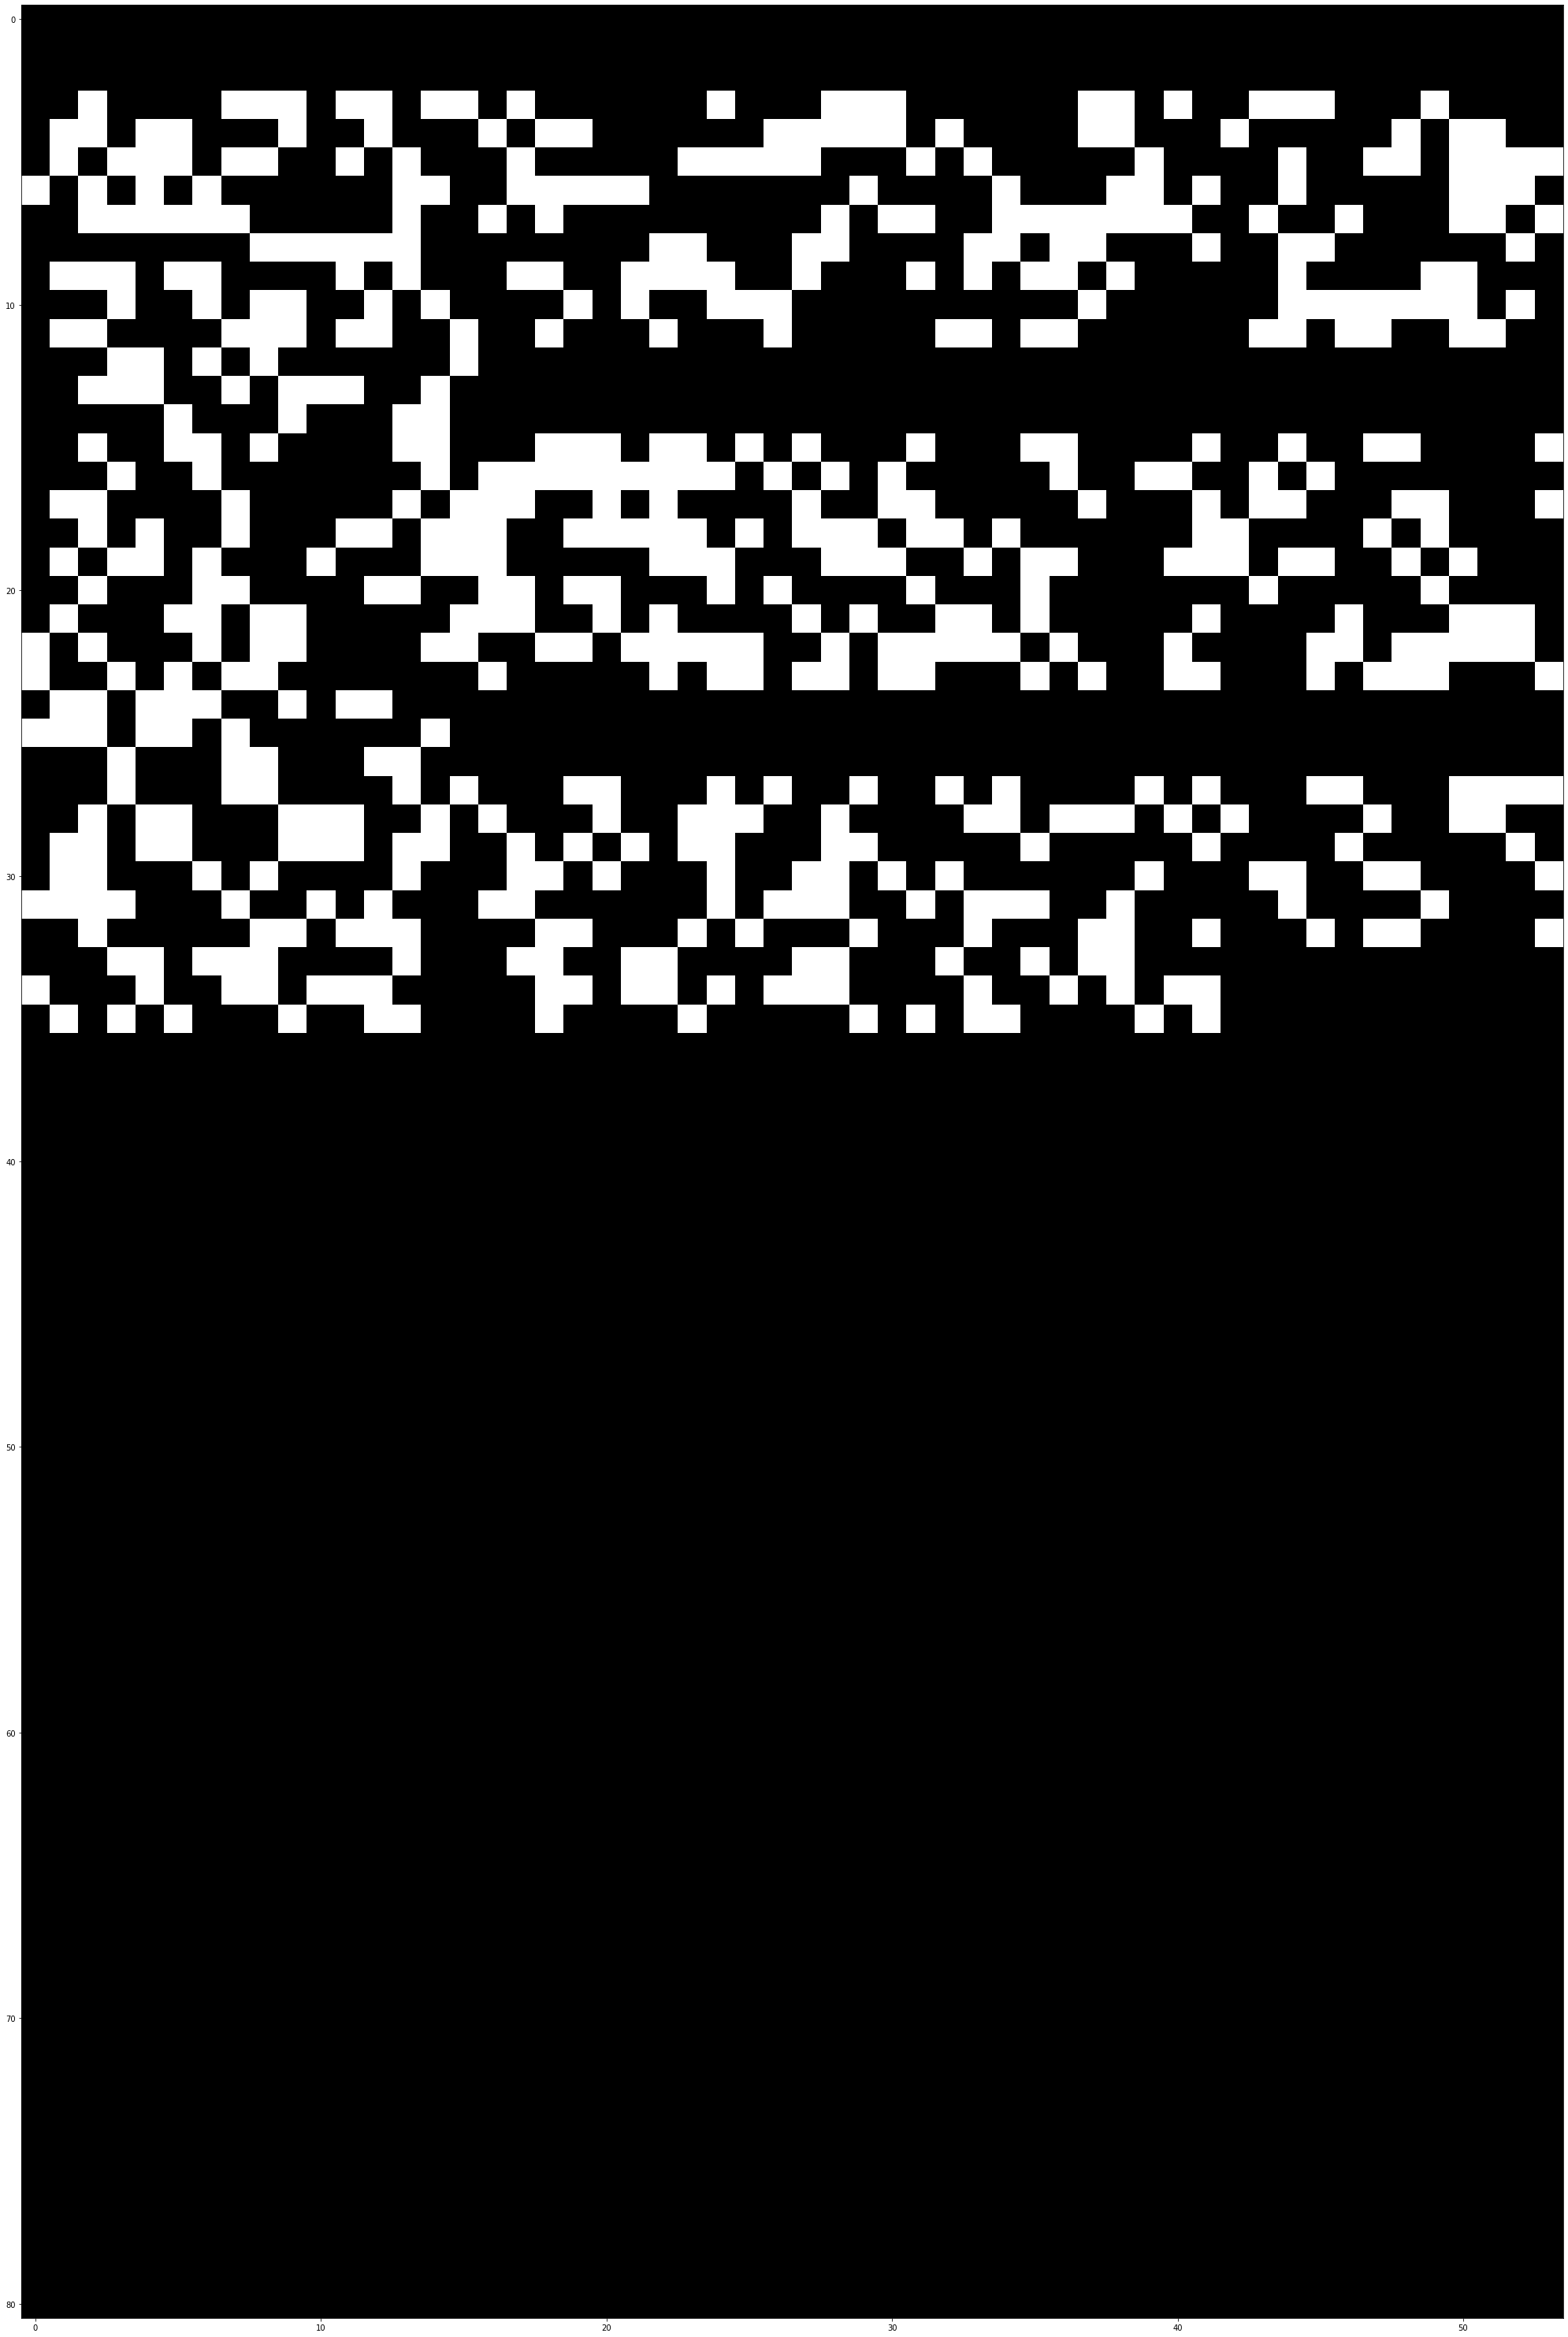

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=br_arr.shape)
plt.imshow(a4, cmap='gray')

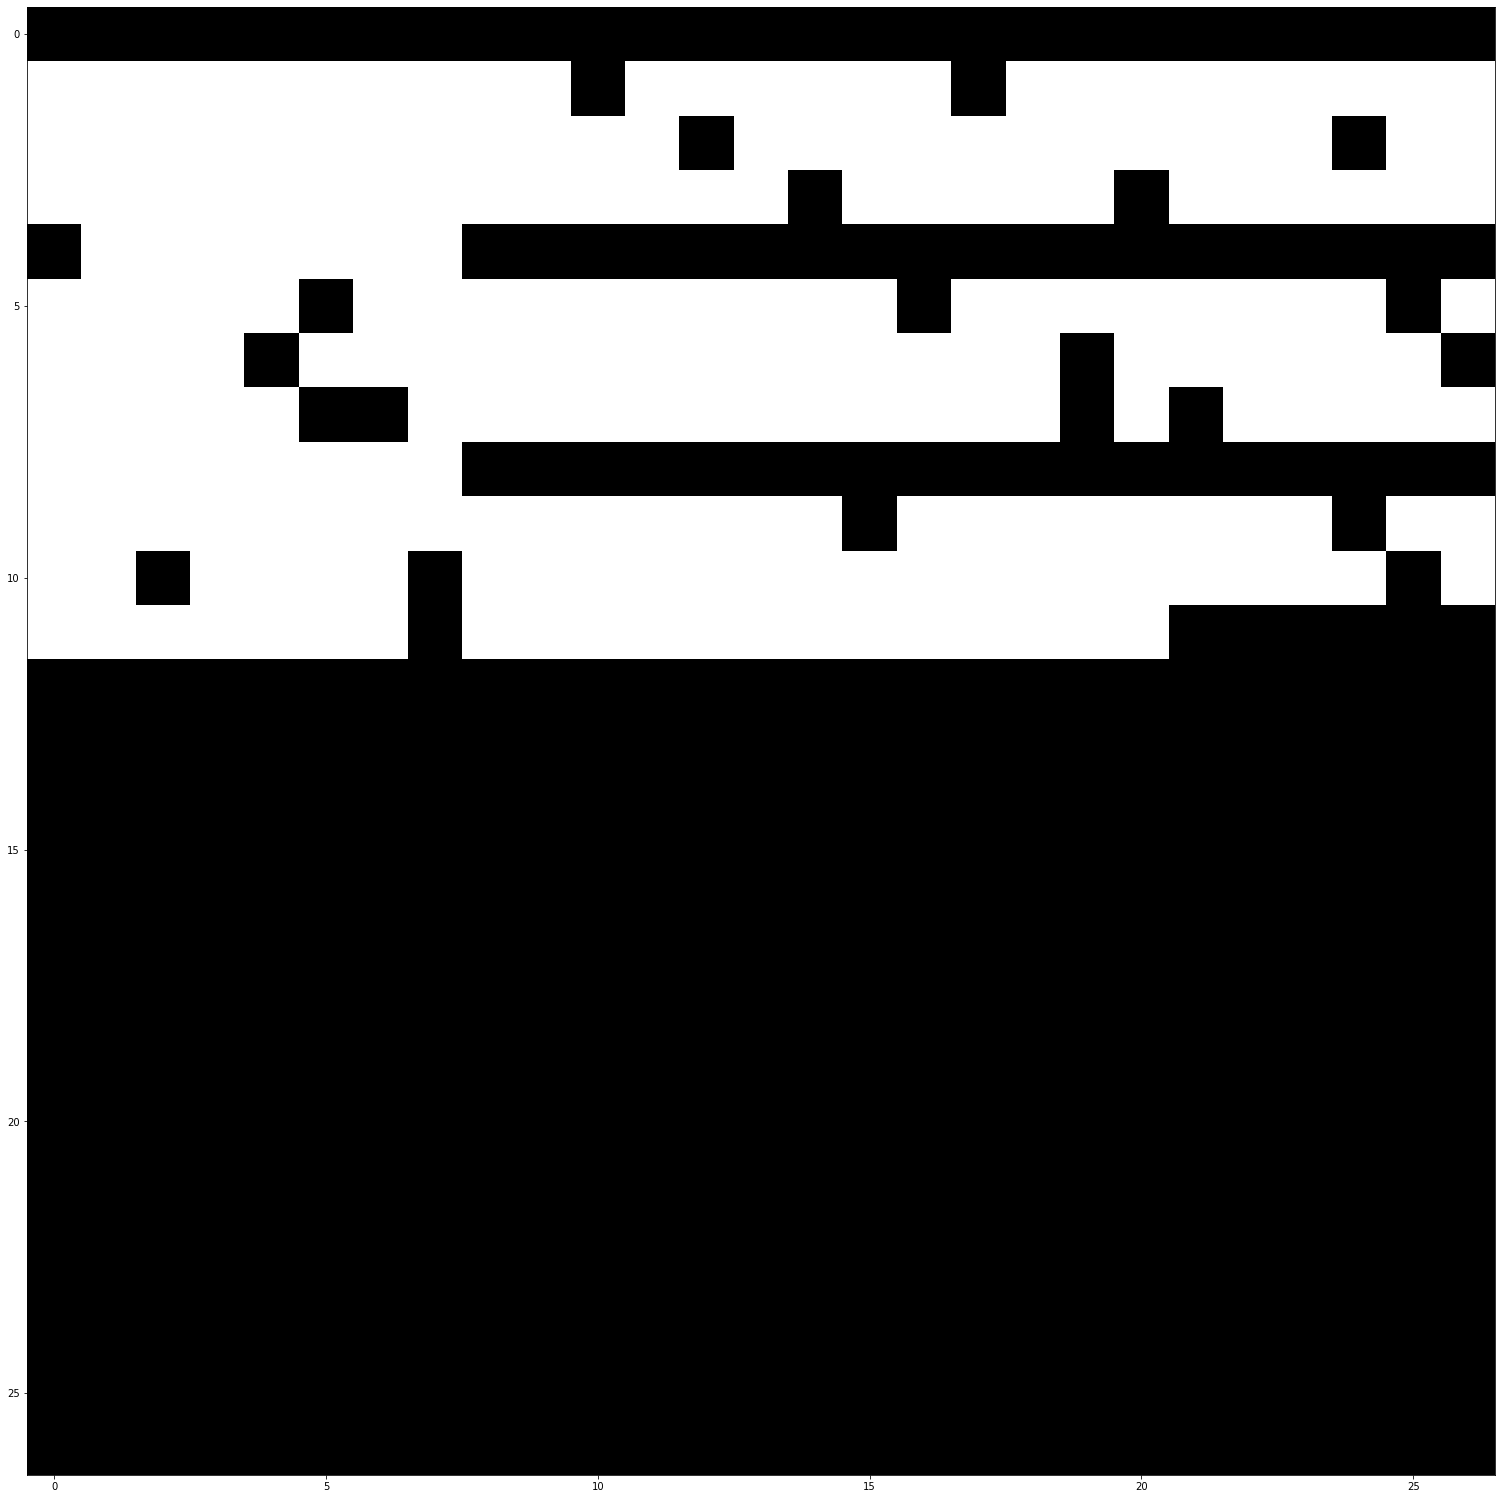

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=[MAX_X_LINE, MAX_Y_LINE])
plt.imshow(a4_to_block(a4), cmap='gray')

In [192]:
def a4_to_serial(input_a4, cursor=np.array([0, 0])):
    return_serial = []
    block = a4_to_block(input_a4)
    vol_cursor = np.array(cursor)

    for i in range(len(input_a4)):
        for j in range(len(input_a4[0])):
            if input_a4[i][j] != 0:
                return_serial.append('p')
            vol_cursor[0] += 1
            if vol_cursor[0] % 2 == 0:
                return_serial.append('R')
            else:
                return_serial.append('r')
            if vol_cursor[0] == len(input_a4[0]):
                while vol_cursor[0] != 0:
                    vol_cursor -= 1
                    if vol_cursor[0] % 2 == 0:
                        return_serial.append('l')
                    else:
                        return_serial.append('L')
                vol_cursor[1] += 1
    return return_serial
                

In [193]:
a4_to_serial(a4)

['r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'L',
 'l',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'r',
 'R',
 'L',
 'l',
 'L',
 'l',
 'L'

In [181]:
def direction_mov(input_a4, direction, input_list, vol_block_cursor, vol_cursor):
    return_list = []
    if direction == 'r':
        for i in range(len(input_list)):
            if input_a4[vol_cursor[1]][vol_cursor[0]] != 0:
                return_list.append('p')
            vol_cursor[0] += 1
            if vol_cursor[0] / 2 == 0:
                return_list.append('R')
            else:
                return_list.append('r')
            print(return_list[-1])
    elif direction == 'l':
        for i in range(len(input_list)):
            if input_a4[vol_cursor[1]][vol_cursor[0]] != 0:
                return_list.append('p')
            vol_cursor[0] += 1
            if vol_cursor[0] / 2 == 0:
                return_list.append('L')
            else:
                return_list.append('l')
            print(return_list[-1])
    return return_list

In [182]:
def a4_to_serial(input_a4, cursor=np.array([0, 0])):
    return_serial = []
    block = a4_to_block(input_a4)
    vol_cursor = np.array(cursor)

    writing_line_interrupt = 0 #줄바뀔시 인터럽트
    writing_state = 0 # 0이면 작성중인 상태 1이면 움직여야 하는 상태
    
    while True:
        print(vol_cursor)
        vol_block_cursor = np.trunc([vol_cursor[0] / 2, vol_cursor[1] / 3])
        vol_block_cursor = vol_block_cursor.astype(np.int32)
        st_point, end_point = return_two_end_points(block[vol_block_cursor[1]])

        if st_point == -1 and end_point == -1:
            """아래로 내려"""
            vol_cursor[1] += 3
            return_serial.append('d')
            return_serial.append('d')
            return_serial.append('D')
        else:
            if vol_block_cursor[0] < st_point:
                vol_list = direction_mov('r', input_a4[vol_cursor: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                for i in range(len(vol_list)):
                    return_serial.append(vol_list[i])
                vol_cursor[1] += 1
                return_serial.append('d')
                vol_list = direction_mov('l', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                for i in range(len(vol_list)):
                    return_serial.append(vol_list[i])
                vol_cursor[1] += 1
                return_serial.append('d')
                vol_list = direction_mov('r', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                for i in range(len(vol_list)):
                    return_serial.append(vol_list[i])
                vol_cursor[1] += 1
                return_serial.append('D')
                    
            elif vol_block_cursor[0] >= st_point and vol_block_cursor[0] <= end_point:
                if vol_block_cursor[0] - st_point <= end_point - vol_block_cursor[0]:
                    while vol_cursor[0] != 2 * st_point:
                        vol_cursor -= 1
                        if vol_cursor[0] / 2 == 0:
                            return_list.append('R')
                        else:
                            return_list.append('r')
                    vol_list = direction_mov(input_a4, 'r', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                    for i in range(len(vol_list)):
                        return_serial.append(vol_list[i])
                    vol_cursor[1] += 1
                    return_serial.append('d')
                    vol_list = direction_mov(input_a4, 'l', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                    for i in range(len(vol_list)):
                        return_serial.append(vol_list[i])
                    vol_cursor[1] += 1
                    return_serial.append('d')
                    vol_list = direction_mov(input_a4, 'r', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                    for i in range(len(vol_list)):
                        return_serial.append(vol_list[i])
                    vol_cursor[1] += 1
                    return_serial.append('D')
                else:
                    while vol_cursor[0] != 2 * st_point:
                        vol_cursor -= 1
                        if vol_cursor[0] / 2 == 0:
                            return_list.append('L')
                        else:
                            return_list.append('l')
                    vol_list = direction_mov(input_a4, 'l', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                    for i in range(len(vol_list)):
                        return_serial.append(vol_list[i])
                    vol_cursor[1] += 1
                    return_serial.append('d')
                    vol_list = direction_mov(input_a4, 'r', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                    for i in range(len(vol_list)):
                        return_serial.append(vol_list[i])
                    vol_cursor[1] += 1
                    return_serial.append('d')
                    vol_list = direction_mov(input_a4, 'l', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                    for i in range(len(vol_list)):
                        return_serial.append(vol_list[i])
                    vol_cursor[1] += 1
                    return_serial.append('D')
            
            elif vol_block_cursor[0] > end_point:
                vol_list = direction_mov(input_a4, 'l', input_a4[vol_cursor: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                for i in range(len(vol_list)):
                    return_serial.append(vol_list[i])
                vol_cursor[1] += 1
                return_serial.append('d')
                vol_list = direction_mov(input_a4, 'r', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                for i in range(len(vol_list)):
                    return_serial.append(vol_list[i])
                vol_cursor[1] += 1
                return_serial.append('d')
                vol_list = direction_mov(input_a4, 'l', input_a4[2 * st_point: 2 * end_point + 2], vol_block_cursor, vol_cursor)
                for i in range(len(vol_list)):
                    return_serial.append(vol_list[i])
                vol_cursor[1] += 1
                return_serial.append('D')
        if vol_cursor[1] == 3 * MAX_Y_LINE:
            break

In [183]:
a4_to_serial(a4)

[0 0]
[0 3]
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r


IndexError: index 54 is out of bounds for axis 0 with size 54

In [82]:
np.trunc(list3)

array([0., 0., 1., 1.])

In [83]:
tuple1 = (2, 3)

In [84]:
list4 = np.array([[1, 1, 1, 1, 1, 1, 1], [0, 1, 0, 0, 0, 1, 1], [0, 1, 1, 1, 1, 1, 1]])

In [103]:
return_two_end_points(a4_to_block(a4)[4])

(1, 7)

In [118]:
a4_to_block(a4)[4]

array([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [162]:
a4[(10, 71)]

IndexError: index 71 is out of bounds for axis 1 with size 54

In [185]:
def test_func(a):
    global a
    a = 3

SyntaxError: name 'a' is parameter and global (<ipython-input-185-dd77a804d81d>, line 5)